In [11]:
%matplotlib inline

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt 
import numpy as np 
import torch

from matplotlib import animation 
from IPython.display import HTML 
from collections import defaultdict


In [244]:
# cost function 
def cost_func(x=None, y=None, funcname='default'):
    '''Cost function. 
    Args: 
        x: Numpy ndarray 
        y: Numpy ndarray
    '''
    if funcname=='himmelblau':
        z = __himmelblau(x, y)
        return z
    if funcname == 'saddle':
        z = __saddle(x, y)
        return z
    if funcname == 'default':
        z = __f1(x, y)
        z -=  0.6 * __f2(x, y, x_mean=-0.4, y_mean=-0.5, x_sig=0.35, y_sig=0.35)
        return z
    # z = -1. * __f2(x, y, x_mean=-0.5, y_mean=-0.8, x_sig=0.35, y_sig=0.35)

    # three steep gaussian trenches
    # z -= __f2(x, y, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    # z -= __f2(x, y, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    # z -= __f2(x, y, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    # z += __f2(x, y, x_mean=0.5, y_mean=0.8, x_sig=0.8, y_sig=0.2)

    # z -= __f2(x, y, x_mean=-1.0, y_mean=0.5, x_sig=0.15, y_sig=0.25)
    # z += __f2(x, y, x_mean=0.5, y_mean=0.8, x_sig=0.6, y_sig=0.6)
    return z

def __saddle(x, y):
    return torch.pow(x, 2) - torch.pow(y, 2)

def __himmelblau(x, y):
    return torch.pow(x * x + y - 11, 2) + torch.pow(x + y * y - 7, 2)

def __f1(x, y):
    return -1 * torch.sin(x * x) * torch.cos(3 * y * y) * torch.exp(-(x * y) * (x * y)) - torch.exp(-(x + y) * (x + y))

# Bivar gaussian hills of the cost function 
def __f2(x, y, x_mean, y_mean, x_sig, y_sig):
    normalizing = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * torch.square(x - x_mean)) / (2 * x_sig**2)
    y_exp = (-1 * torch.square(y - y_mean)) / (2 * y_sig**2)
    return normalizing * torch.exp(x_exp + y_exp)

# visualize cost function as a contour plot
x_val = y_val = np.arange(-1.5, 1.5, 0.005, dtype=np.float32)
x_val_mesh, y_val_mesh = np.meshgrid(x_val, y_val)
x_val_mesh_flat = torch.tensor(x_val_mesh.reshape([-1, 1]))
y_val_mesh_flat = torch.tensor(y_val_mesh.reshape([-1, 1]))

z_val_mesh_flat = cost_func(x_val_mesh_flat, y_val_mesh_flat)
z_val_mesh = torch.squeeze(z_val_mesh_flat).numpy().reshape(x_val_mesh.shape)

In [245]:
# Starting location for variabels
x_i = torch.tensor([0.9], requires_grad=True)
y_i = torch.tensor([1.], requires_grad=True)
z_i = cost_func(x_i, y_i)
# Add them to the plot
z_i

tensor([0.2919], grad_fn=<SubBackward0>)

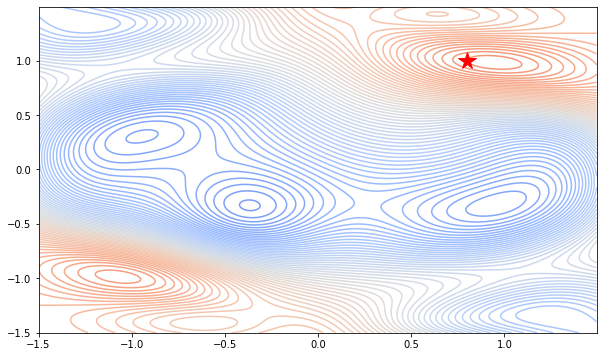

In [246]:
# Draw 2D contour
fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x_val_mesh, y_val_mesh, z_val_mesh, levels=np.linspace(-2, 1, 100), cmap=plt.cm.coolwarm)
ax.plot([0.8], [1.], 'r*', markersize=18)
plt.draw()

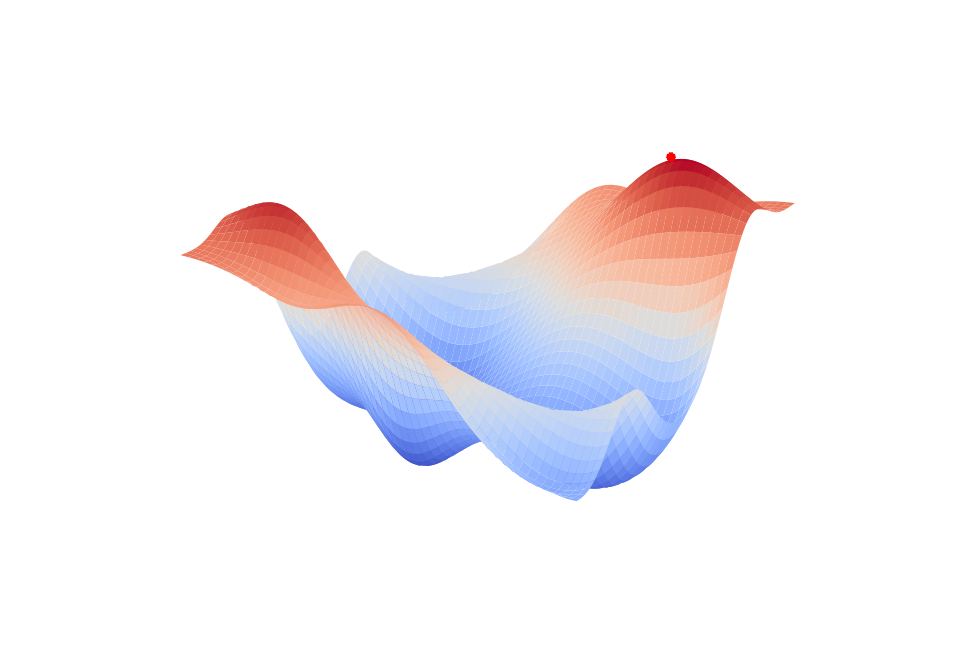

In [247]:
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = fig.add_subplot(111, projection='3d')


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
params = {'legend.fontsize': 3,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.axis('off')

ax.plot_surface(x_val_mesh, y_val_mesh, z_val_mesh, alpha=1, cmap=cm.coolwarm)
ax.plot([0.8], [1.], [0.2919], 'r*', markersize=2, alpha=1, zorder=4)
plt.draw()

In [248]:
ops_param = np.array([['SGD', 0.05, 'r'],
                      ['Adamax', 0.05, 'k'],
                      ['Adam', 0.05, 'g'],
                      ['RMSprop', 0.02, 'b'],
                      ['Adadelta', 20.0, 'c'],
                      ['Adagrad', 0.1, 'm']])

In [249]:
ops_param

array([['SGD', '0.05', 'r'],
       ['Adamax', '0.05', 'k'],
       ['Adam', '0.05', 'g'],
       ['RMSprop', '0.02', 'b'],
       ['Adadelta', '20.0', 'c'],
       ['Adagrad', '0.1', 'm']], dtype='<U32')

In [250]:
methods = list(ops_param[:, 0])

In [255]:
# Extended to multiple method, suppose I have 2 methods
x_var, y_var = [], []
for i in range(len(ops_param)):
    x_var.append(torch.tensor([0.8], requires_grad=True))
    y_var.append(torch.tensor([1.], requires_grad=True))

In [256]:
paths_ = defaultdict(list)
x0 = np.array([.8, 1.])
for method in methods:
    paths_[method].append(x0)

In [257]:
print(paths_)

defaultdict(<class 'list'>, {'SGD': [array([0.8, 1. ])], 'Adamax': [array([0.8, 1. ])], 'Adam': [array([0.8, 1. ])], 'RMSprop': [array([0.8, 1. ])], 'Adadelta': [array([0.8, 1. ])], 'Adagrad': [array([0.8, 1. ])]})


In [258]:
# Multiple optimizers
epochs = 100

ops = []
for i in range(len(ops_param)):
    ops.append(getattr(torch.optim, methods[i])([x_var[i], y_var[i]], lr=float(ops_param[i, 1])))

for i, op in enumerate(ops):
    for epoch in range(epochs):
    
        # Zero grad 
        op.zero_grad()

        # Compute loss
        loss = cost_func(x_var[i], y_var[i])

        # Backward pass to get gradients
        loss.backward()

        # Update params
        op.step()

        # Clone the new state and push it into the path
        paths_[methods[i]].append(np.array([x_var[i].clone().detach().item(), 
                                            y_var[i].clone().detach().item()]))
        

In [259]:
# Ok we have 2 paths, need to visualize them
paths = [np.array(paths_[method]).T for method in methods]

In [260]:
zpaths = [cost_func(torch.tensor(path[0]), torch.tensor(path[1])).numpy() for path in paths]

In [261]:
# Modifing the Class 

class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, *paths, zpaths, labels=[], ops_param=None, fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=100, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        self.labels = labels
        self.ops_param = ops_param
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], 
                              label=label,
                              color=param[2],
                              lw=0.5,
                              zorder=3)[0] 
                      for _, label, param in zip(paths, labels, ops_param)]

        self.points = [ax.scatter([], [], [], s=3, depthshade=True, color=param[2], zorder=3) 
                                  for _, label, param in zip(paths, labels, ops_param)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        print("===============")
        return self.lines + self.points

    def animate(self, i):
        for idx, (line, path, zpath, param) in enumerate(zip(self.lines, self.paths, self.zpaths, self.ops_param)):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
            if self.points[idx]:
                self.points[idx].remove()
            self.points[idx] = self.ax.scatter(*path[::,i], zpath[i], s=2, depthshade=True, color=param[2], zorder=3)
        return self.lines + self.points

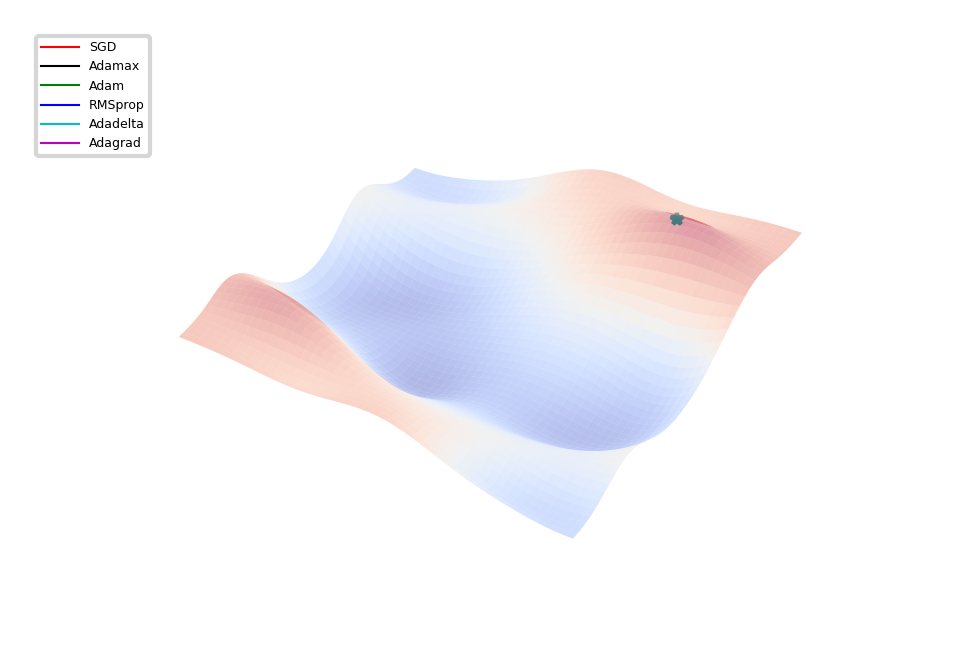

In [265]:
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = fig.add_subplot(111, projection='3d')


xlm = ax.get_xlim3d()
ylm = ax.get_ylim3d()
zlm = ax.get_zlim3d()


azm = ax.azim 
ele = ax.elev + 40
ax.view_init(elev=ele, azim=azm)


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
params = {'legend.fontsize': 3,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.axis('off')

ax.plot_surface(x_val_mesh, y_val_mesh, z_val_mesh, alpha=0.4, cmap=cm.coolwarm)
ax.plot([.8], [1.], [0.2919], 'c*', markersize=3, alpha=1)


anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, labels=methods,ops_param=ops_param,  ax=ax)

ax.legend(loc='upper left')

In [266]:
HTML(anim.to_html5_video())